# Final Project

In [68]:
# 移除不必要的警告
import warnings
warnings.filterwarnings('ignore')

### 獲取歷史資料

In [2]:
from ml_finlab.data import Data
#from finlab.backtest import sim

data = Data()

rev = data.get("當月營收")

close = data.get_adj("收盤價")
open_ = data.get_adj("開盤價")
high = data.get_adj("最高價")
low = data.get_adj("最低價")
vol = data.get("成交股數")

PB = data.get("股價淨值比")
pe = data.get("本益比")
DY = data.get("殖利率(%)")

rev.index = rev.index.shift(3, "d")

In [3]:
close

stock_id,0015,0050,0051,0052,0053,0054,0055,0056,0057,0058,...,9944,9945,9946,9949,9950,9951,9955,9958,9960,9962
date,,,,,,,,,,,,,,,,,,,,,
2007-04-23,9.54,57.850000,32.830000,38.400000,NaN,NaN,NaN,NaN,NaN,NaN,...,31.000000,30.350000,9.780000,73.600000,13.250000,51.300000,72.400000,NaN,46.000000,49.600000
2007-04-24,9.54,58.100000,32.990000,38.650000,NaN,NaN,NaN,NaN,NaN,NaN,...,32.000000,30.500000,9.910000,75.000000,13.250000,50.500000,71.600000,NaN,45.900000,50.400000
2007-04-25,9.52,57.600000,32.800000,38.590000,NaN,NaN,NaN,NaN,NaN,NaN,...,32.300000,29.500000,10.100000,74.600000,13.300000,49.900000,71.600000,NaN,49.100000,49.100000
2007-04-26,9.59,57.700000,32.800000,38.600000,NaN,NaN,NaN,NaN,NaN,NaN,...,31.600000,29.150000,10.800000,74.500000,13.250000,49.500000,71.000000,NaN,48.900000,48.000000
2007-04-27,9.55,57.500000,32.720000,38.400000,NaN,NaN,NaN,NaN,NaN,NaN,...,31.400000,28.500000,11.550000,75.700000,13.150000,48.800000,69.500000,NaN,48.600000,46.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-05,NaN,227.643006,118.916194,210.427234,107.176575,NaN,36.567787,80.359256,99.351100,NaN,...,35.976521,158.766318,48.748228,22.459606,47.719643,174.398722,32.446949,277.281021,79.011781,43.559299
2023-12-06,NaN,228.428885,120.018055,211.288582,108.275018,NaN,36.861318,80.955359,99.923579,NaN,...,36.064915,161.142412,48.056764,22.894308,49.279709,173.272116,32.319706,278.830077,79.157291,43.559299
2023-12-07,NaN,227.031767,119.594262,209.996560,107.804257,NaN,36.614134,80.817797,99.403144,NaN,...,35.976521,159.414344,44.023222,22.894308,49.463246,175.750650,31.747113,281.928189,79.157291,43.436941


### 計算features

In [4]:
def bias(n):
    return close / close.rolling(n, min_periods=1).mean()

def acc(n):
    return close.shift(n) / (close.shift(2*n) + close) * 2

def rsv(n):
    l = close.rolling(n, min_periods=1).min()
    h = close.rolling(n, min_periods=1).max()
    
    return (close - l) / (h - l)

def mom(n):
    return (rev / rev.shift(1)).shift(n)

#####上為原版資料###
def yoy(n):
    denominator = rev.shift(12 + n)
    result = rev.shift(n) / denominator - 1
    result[denominator < 0] = 0  # 如果分母为负，将对应的结果设置为0
    return result

def delta_yoy(n):
    yoy_current = yoy(n)
    yoy_previous = yoy(n + 1)
    delta = yoy_current - yoy_previous
    return delta

def willr(n):
    highest_high = high.rolling(n, min_periods=1).max()
    lowest_low = low.rolling(n, min_periods=1).min()
    willr = (highest_high - close) / (highest_high - lowest_low) * -100
    return willr

def linearreg_slope(n):
    slope = (close - close.shift(n)) / n
    return slope

def adx(n):
    true_range = high - low
    true_range = true_range.fillna(0)
    
    plus_dm = high.diff()
    minus_dm = low.diff()
    plus_dm[plus_dm < 0] = 0
    minus_dm[minus_dm > 0] = 0
    
    plus_dm = plus_dm.rolling(n).sum()
    minus_dm = minus_dm.abs().rolling(n).sum()
    
    tr_sum = true_range.rolling(n).sum()
    tr_sum[tr_sum == 0] = 0.0001
    
    plus_di = (plus_dm / tr_sum) * 100
    minus_di = (minus_dm / tr_sum) * 100
    
    dx = ((plus_di - minus_di).abs() / (plus_di + minus_di).abs()) * 100
    adx = dx.rolling(n).mean()
    
    return adx


def adxr(n):
    adx_value = adx(n)  # 先計算ADX值
    adxr = adx_value.rolling(n).mean()  # 計算ADX值的平均值
    return adxr

def rsi(n):
    diff = close.diff()
    up = diff.where(diff > 0, 0)
    down = -diff.where(diff < 0, 0)
    avg_gain = up.rolling(n).mean()
    avg_loss = down.rolling(n).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def kd(n):
    l = close.rolling(n).min()
    h = close.rolling(n).max()
    rsv = (close - l) / (h - l)
    k = rsv.rolling(3).mean()
    d = k.rolling(3).mean()
    return k - d


#---------

def ma_ratio(n):
    ma_short = close.rolling(n).mean()
    ma_long = close.rolling(2 * n).mean()
    return ma_short / ma_long

def volume_change(n):
    return vol.pct_change(n)

def range_ratio(n):
    range_high = high.rolling(n).max()
    range_low = low.rolling(n).min()
    return (range_high - range_low) / range_low


In [5]:
features = {
    'mom{}'.format(n): mom(n) for n in range(1, 10)
}

features.update({
    'bias_{}'.format(n): bias(n) for n in [5, 10, 20, 60, 120, 240]
})




features.update({
    'acc_{}'.format(n): acc(n) for n in [5, 10, 20, 60, 120, 240]
})

features.update({
    'rsv_{}'.format(n): rsv(n) for n in [5, 10, 20, 60, 120, 240]
})

####上為原版資料###
features.update({
    'PB': PB,
    'PE': pe,
    'DY': DY
})

features.update({
    'yoy_{}'.format(n): yoy(n) for n in range(0, 0)
})
features.update({
    'delta_yoy_{}'.format(n): delta_yoy(n) for n in range(0, 2)
})

#features.update({
#    'willr_{}'.format(n): willr(n) for n in [14, 20, 60]
#})
#
#features.update({
#    'linearreg_slope_{}'.format(n): linearreg_slope(n) for n in [14, 112, 224]
#})
#
#features.update({
#    f'kd_{n}': kd(n) for n in [ 9, 14, 20, 60]
#})
#
#features.update({
#    'adxr_{}'.format(n): adxr(n) for n in [14, 20, 30]
#})
#
#features.update({
#    'ma_ratio_{}'.format(n): ma_ratio(n) for n in [20, 40, 60]
#})
#
#features.update({
#    'volume_change_{}'.format(n): volume_change(n) for n in [20, 40, 60, 120]
#})

#features.update({
#    'range_ratio_{}'.format(n): range_ratio(n) for n in [10, 30, 60]
#})
#

In [6]:
#import pandas as pd
#t1 = pd.read_pickle("history/items/bargin_report/外陸資買賣超股數(不含外資自營商).pkl")
#t2 = pd.read_pickle("history/items/bargin_report/投信買賣超股數.pkl")
#t3 = pd.read_pickle("history/items/bargin_report/自營商買賣超股數(自行買賣).pkl")

### 製作dataset

##### 設定買賣頻率

In [7]:
every_month = rev.index
every_month

DatetimeIndex(['2005-02-13', '2005-03-13', '2005-04-13', '2005-05-13',
               '2005-06-13', '2005-07-13', '2005-08-13', '2005-09-13',
               '2005-10-13', '2005-11-13',
               ...
               '2023-03-13', '2023-04-13', '2023-05-13', '2023-06-13',
               '2023-07-13', '2023-08-13', '2023-09-13', '2023-10-13',
               '2023-11-13', '2023-12-13'],
              dtype='datetime64[ns]', name='date', length=227, freq=None)

##### 將dataframe 組裝起來

In [8]:
# features['bias20'].reindex(every_month, method='ffill')

for name, f in features.items():
    features[name] = f.reindex(every_month, method='ffill')

In [9]:

for name, f in features.items():
    features[name] = f.unstack()

In [10]:
import pandas as pd
dataset = pd.DataFrame(features)

#### 金融股要不要去掉?

In [11]:
##我要把金融股拿掉 所以把28開頭全去掉
#dataset = dataset[~dataset.index.get_level_values('stock_id').str.startswith('28')]

In [12]:
feature_names = list(dataset.columns)
feature_names

['mom1',
 'mom2',
 'mom3',
 'mom4',
 'mom5',
 'mom6',
 'mom7',
 'mom8',
 'mom9',
 'bias_5',
 'bias_10',
 'bias_20',
 'bias_60',
 'bias_120',
 'bias_240',
 'acc_5',
 'acc_10',
 'acc_20',
 'acc_60',
 'acc_120',
 'acc_240',
 'rsv_5',
 'rsv_10',
 'rsv_20',
 'rsv_60',
 'rsv_120',
 'rsv_240',
 'PB',
 'PE',
 'DY',
 'delta_yoy_0',
 'delta_yoy_1']

In [13]:
#del feature_names.iloc['bias_5']

In [14]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
# 對 features 進行正規化
normalized_features = scaler.fit_transform(dataset[feature_names])

# 將正規化後的數據轉換為 DataFrame
normalized_features_df = pd.DataFrame(normalized_features, columns=dataset[feature_names].columns)


In [15]:
#scaler.fit_transform(dataset[feature_names])

In [16]:
dataset[feature_names]

mom1      mom2      mom3      mom4      mom5  \
stock_id date                                                           
0015     2005-02-13       NaN       NaN       NaN       NaN       NaN   
         2005-03-13       NaN       NaN       NaN       NaN       NaN   
         2005-04-13       NaN       NaN       NaN       NaN       NaN   
         2005-05-13       NaN       NaN       NaN       NaN       NaN   
         2005-06-13       NaN       NaN       NaN       NaN       NaN   
...                       ...       ...       ...       ...       ...   
9962     2023-08-13  0.834370  1.250776  0.759387  1.020832  1.110722   
         2023-09-13  0.870248  0.834370  1.250776  0.759387  1.020832   
         2023-10-13  1.565305  0.870248  0.834370  1.250776  0.759387   
         2023-11-13  0.821709  1.565305  0.870248  0.834370  1.250776   
         2023-12-13  0.831003  0.821709  1.565305  0.870248  0.834370   

                         mom6      mom7      mom8      mom9    bias_5  ...  \
stock_id date                                                          ...   
0015     2005-02-13       NaN       NaN       NaN       NaN       NaN  ...   
         2005-03-13       NaN       NaN       NaN       NaN       NaN  ...   
         2005-04-13       NaN       NaN       NaN       NaN       NaN  ...   
         2005-05-13       NaN       NaN       NaN       NaN       NaN  ...   
         2005-06-13       NaN       NaN       NaN       NaN       NaN  ...   
...                       ...       ...       ...       ...       ...  ...   
9962     2023-08-13  0.729045  1.249495  1.004024  1.163303  0.970982  ...   
         2023-09-13  1.110722  0.729045  1.249495  1.004024  1.010759  ...   
         2023-10-13  1.020832  1.110722  0.729045  1.249495  1.004075  ...   
         2023-11-13  0.759387  1.020832  1.110722  0.729045  0.992563  ...   
         2023-12-13  1.250776  0.759387  1.020832  1.110722  0.994927  ...   

                       rsv_10    rsv_20    rsv_60   rsv_120   rsv_240    PB  \
stock_id date                                                                 
0015     2005-02-13       NaN       NaN       NaN       NaN       NaN   NaN   
         2005-03-13       NaN       NaN       NaN       NaN       NaN   NaN   
         2005-04-13       NaN       NaN       NaN       NaN       NaN   NaN   
         2005-05-13       NaN       NaN       NaN       NaN       NaN   NaN   
         2005-06-13       NaN       NaN       NaN       NaN       NaN   NaN   
...                       ...       ...       ...       ...       ...   ...   
9962     2023-08-13  0.038462  0.032258  0.015873  0.010204  0.531834  1.41   
         2023-09-13  0.933333  0.954545  0.283784  0.192661  0.575272  1.45   
         2023-10-13  0.833333  0.294118  0.214286  0.109756  0.497224  1.40   
         2023-11-13  0.363636  0.533333  0.500000  0.148649  0.354783  1.37   
         2023-12-13  0.000000  0.416667  0.666667  0.229730  0.383054  1.40   

                        PE     DY  delta_yoy_0  delta_yoy_1  
stock_id date                                                
0015     2005-02-13    NaN    NaN          NaN          NaN  
         2005-03-13    NaN    NaN          NaN          NaN  
         2005-04-13    NaN    NaN          NaN          NaN  
         2005-05-13    NaN    NaN          NaN          NaN  
         2005-06-13    NaN    NaN          NaN          NaN  
...                    ...    ...          ...          ...  
9962     2023-08-13   8.45  10.34     0.232702    -0.673009  
         2023-09-13   8.67  10.08     0.196563     0.232702  
         2023-10-13   8.37  10.43    -0.011836     0.196563  
         2023-11-13  10.21  10.37    -0.305692    -0.011836  
         2023-12-13  10.38  10.20     0.127807    -0.305692  

[473522 rows x 32 columns]

In [17]:
from ml_finlab import ml

vol=data.get('成交股數')/1000
vol_ma5=vol.rolling(20).mean()

股本 = data.get('股本合計').reindex(close.index, method='ffill')
市值 = 股本 * close / 10 * 1000

In [18]:
ml.add_feature(dataset, 'vol_ma5', vol_ma5)

ml.add_feature(dataset, '市值', 市值)

### 新增 label

In [19]:
from ml_finlab import ml

ml.add_profit_prediction(dataset)
ml.add_rank_prediction(dataset)

### 刪除太大太小的歷史資料

In [20]:
print(dataset.shape)

def drop_extreme_case(dataset, feature_names, thresh=0.01):
    
    extreme_cases = pd.Series(False, index=dataset.index)
    for f in feature_names:
        tf = dataset[f]
        extreme_cases = extreme_cases | (tf < tf.quantile(thresh)) | (tf > tf.quantile(1-thresh))
    dataset = dataset[~extreme_cases]
    return dataset

dataset_drop_extreme_case = drop_extreme_case(dataset,
                                              feature_names, thresh=0.01)

print(dataset_drop_extreme_case.shape)

(473522, 36)
(407269, 36)


In [21]:
dataset_dropna = dataset_drop_extreme_case.dropna(how='any')
dataset_dropna = dataset_dropna.reset_index().set_index("date")

In [22]:
dataset_drop_extreme_case.index.get_level_values("date")

DatetimeIndex(['2005-02-13', '2005-03-13', '2005-04-13', '2005-05-13',
               '2005-06-13', '2005-07-13', '2005-08-13', '2005-09-13',
               '2005-10-13', '2005-11-13',
               ...
               '2023-03-13', '2023-04-13', '2023-05-13', '2023-06-13',
               '2023-07-13', '2023-08-13', '2023-09-13', '2023-10-13',
               '2023-11-13', '2023-12-13'],
              dtype='datetime64[ns]', name='date', length=407269, freq=None)

In [23]:
dataset_drop_extreme_case.tail()

mom1      mom2      mom3      mom4      mom5  \
stock_id date                                                           
9962     2023-08-13  0.834370  1.250776  0.759387  1.020832  1.110722   
         2023-09-13  0.870248  0.834370  1.250776  0.759387  1.020832   
         2023-10-13  1.565305  0.870248  0.834370  1.250776  0.759387   
         2023-11-13  0.821709  1.565305  0.870248  0.834370  1.250776   
         2023-12-13  0.831003  0.821709  1.565305  0.870248  0.834370   

                         mom6      mom7      mom8      mom9    bias_5  ...  \
stock_id date                                                          ...   
9962     2023-08-13  0.729045  1.249495  1.004024  1.163303  0.970982  ...   
         2023-09-13  1.110722  0.729045  1.249495  1.004024  1.010759  ...   
         2023-10-13  1.020832  1.110722  0.729045  1.249495  1.004075  ...   
         2023-11-13  0.759387  1.020832  1.110722  0.729045  0.992563  ...   
         2023-12-13  1.250776  0.759387  1.020832  1.110722  0.994927  ...   

                      rsv_240    PB     PE     DY  delta_yoy_0  delta_yoy_1  \
stock_id date                                                                 
9962     2023-08-13  0.531834  1.41   8.45  10.34     0.232702    -0.673009   
         2023-09-13  0.575272  1.45   8.67  10.08     0.196563     0.232702   
         2023-10-13  0.497224  1.40   8.37  10.43    -0.011836     0.196563   
         2023-11-13  0.354783  1.37  10.21  10.37    -0.305692    -0.011836   
         2023-12-13  0.383054  1.40  10.38  10.20     0.127807    -0.305692   

                       vol_ma5            市值    return      rank  
stock_id date                                                     
9962     2023-08-13  301.89820  3.841620e+09  1.050000  0.677520  
         2023-09-13  213.37910  3.940972e+09  0.960784  0.279070  
         2023-10-13  150.13285  3.808502e+09  1.011662  0.634202  
         2023-11-13  138.59650  3.830581e+09       NaN       NaN  
         2023-12-13  156.16825  3.896816e+09       NaN       NaN  

[5 rows x 36 columns]

## Split Train Test dataset

In [24]:
dataset_unique = dataset_dropna.index.astype(str).drop_duplicates().sort_values()
dataset_unique

# 計算要分割的索引位置
split_index = int(len(dataset_unique) * 0.8)
Bef = dataset_unique[split_index] 
Aft = dataset_unique[split_index+1]


# 分割資料集
dataset_train = dataset_dropna.loc[:Bef]
dataset_test = dataset_dropna.loc[Aft:]
print(f'切割時間在{Bef}之前與{Aft}後')

切割時間在2021-10-13之前與2021-11-13後


In [25]:
#profit(return) rank
predi_target = 'rank'

In [26]:
train = dataset_train[feature_names].astype(float) , dataset_train[predi_target] #> 1.00
test = dataset_test[feature_names].astype(float) , dataset_test[predi_target] #> 1.00

### 1.神經網路模型

In [27]:
from tensorflow import keras

tf_callback = keras.callbacks.TensorBoard(log_dir="./logs")

2023-12-12 11:20:50.760475: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-12 11:20:51.751454: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-12-12 11:20:51.751512: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-12-12 11:20:53.486494: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [28]:
#from tensorflow import keras
#from tensorflow.keras import layers
#from tensorflow.keras import initializers
#
##import keras
##from keras.initializers import he_normal
#from tensorflow.keras.initializers import he_normal
#import os
#
#
#os.environ['KMP_DUPLICATE_LIB_OK']='True'
#
#model = keras.models.Sequential()
#model.add(keras.layers.Dense(100, activation='relu',
#                      input_shape=(len(feature_names),),
#                      kernel_initializer=he_normal(seed=0)))
#model.add(keras.layers.Dense(100, activation='relu',
#                      kernel_initializer=he_normal(seed=0)))
#model.add(keras.layers.Dropout(0.7))
#model.add(keras.layers.Dense(1, activation='sigmoid'))
#
#
#model.summary()
#
#model.compile(loss='mean_squared_error',
#              optimizer="adam",)
#
#print('start fitting')
#history = model.fit(dataset_train[feature_names], dataset_train[predi_target],
#                    batch_size=1000,
#                    epochs=225,
#                    verbose=1,
#                    validation_split=0.1, )
#

In [29]:
#index = feature_names.index('rsv_5')
#if index!= -1:
#    del feature_names[index]

In [30]:
#feature_names

In [31]:
import os

#from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import initializers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

os.environ['KMP_DUPLICATE_LIB_OK']='True'

model = keras.models.Sequential()
model.add(layers.Dense(100, activation='relu',
                      input_shape=(len(feature_names),),
                      kernel_initializer=initializers.he_normal(seed=0)))
model.add(layers.Dense(100, activation='relu',
                      kernel_initializer=initializers.he_normal(seed=0)))
model.add(layers.Dropout(0.7))
model.add(layers.Dense(1, activation='sigmoid'))

# 摘要模型
model.summary()

# 建立優化器
#optimizer = keras.optimizers.Adam(learning_rate=0.001)

# 建立損失函數和評估指標
model.compile(loss='mean_squared_error',
              optimizer="adam",
              #metrics='accuracy'
             )

# 設定早停
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

# 設定模型回檔
get_best_model = keras.callbacks.ModelCheckpoint(
    filepath='./best_model/v2_15.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1,
    patience=10,
    save_best_only=True)

# 訓練模型
history = model.fit(dataset_train[feature_names],
                    dataset_train[predi_target],
                    batch_size=888,
                    epochs=225,
                    verbose=1,
                    validation_split=0.1,
                    callbacks=[get_best_model, tf_callback]) #es, get_best_model


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               3300      
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 


2023-12-12 11:20:58.436370: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-12-12 11:20:58.436413: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (fred-finlab): /proc/driver/nvidia/version does not exist
2023-12-12 11:20:58.438400: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Total params: 13,501
Trainable params: 13,501
Non-trainable params: 0
_________________________________________________________________
Epoch 1/225
75/85 [=========================>....] - ETA: 0s - loss: 0.1447
Epoch 1: val_loss improved from inf to 0.07198, saving model to ./best_model/v2_15.h5
85/85 [==============================] - 1s 5ms/step - loss: 0.1363 - val_loss: 0.0720
Epoch 2/225
79/85 [==========================>...] - ETA: 0s - loss: 0.0714
Epoch 2: val_loss improved from 0.07198 to 0.07190, saving model to ./best_model/v2_15.h5
85/85 [==============================] - 1s 6ms/step - loss: 0.0714 - val_loss: 0.0719
Epoch 3/225
78/85 [==========================>...] - ETA: 0s - loss: 0.0714
Epoch 3: val_loss improved from 0.07190 to 0.07188, saving model to ./best_model/v2_15.h5
85/85 [==============================] - 0s 3ms/step - loss: 0.0714 - val_loss: 0.0719
Epoch 4/225
77/85 [==========================>...] - ETA: 0s - loss: 0.0713
Epoch 4: val_loss did not improve

In [32]:
#import os
#os.environ['CUDA_VISIBLE_DEVICES'] = ''
#import tensorflow as tf
#tf.config.list_physical_devices('GPU')

#### 結果

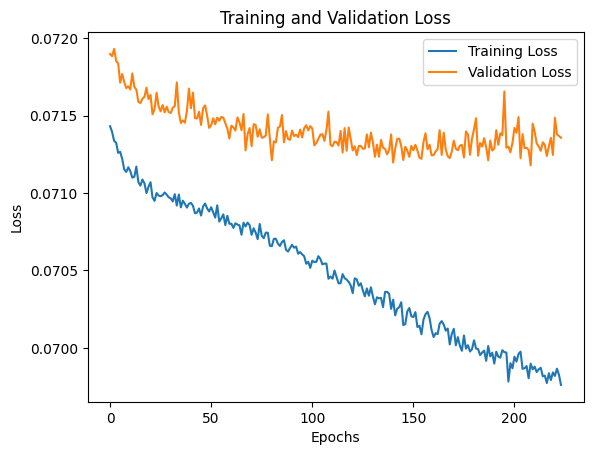

In [69]:
import matplotlib.pyplot as plt
%matplotlib inline

# 訓練過程中的損失函數
train_loss = history.history['loss'][1:]
val_loss = history.history['val_loss'][1:]

# 繪製損失函數圖表
plt.plot(range(len(train_loss)), train_loss, label='Training Loss')
plt.plot(range(len(val_loss)), val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

### 2.lightgbm Model

In [34]:
import lightgbm as lgb
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
from sklearn.model_selection import RandomizedSearchCV

fit_params = {
    "early_stopping_rounds": 30,
    "eval_metric": 'rmse',  # 設置為 RMSE
    "eval_set": [(test[0], test[1])],
    'eval_names': ['valid'],
    'verbose': 100,
    'categorical_feature': 'auto'
}

param_test = {
    'num_leaves': sp_randint(10, 100),
    'min_child_samples': sp_randint(50, 200),
    'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
    'subsample': sp_uniform(loc=0.1, scale=0.9),
    'colsample_bytree': sp_uniform(loc=0.2, scale=0.8),
    'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
    'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]
}

# 調整為較小的值，例如100
n_HP_points_to_test = 100

# 將n_estimators設置為10000
clf = lgb.LGBMRegressor(max_depth=-1, random_state=314, silent=True, metric='None', n_jobs=4, n_estimators=10000)

gs = RandomizedSearchCV(
    estimator=clf, param_distributions=param_test,
    n_iter=n_HP_points_to_test,
    scoring='neg_mean_squared_error',
    cv=3,
    refit=True,
    random_state=314,
    verbose=True
)


In [35]:
# 替換為實際的訓練數據和適合的參數
gs.fit(*train, **fit_params)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Training until validation scores don't improve for 30 rounds
[100]	valid's rmse: 0.269612
Early stopping, best iteration is:
[73]	valid's rmse: 0.269536
Training until validation scores don't improve for 30 rounds
[100]	valid's rmse: 0.269763
Early stopping, best iteration is:
[86]	valid's rmse: 0.269697
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[63]	valid's rmse: 0.269539
Training until validation scores don't improve for 30 rounds
[100]	valid's rmse: 0.27024
Early stopping, best iteration is:
[117]	valid's rmse: 0.270218
Training until validation scores don't improve for 30 rounds
[100]	valid's rmse: 0.27037
[200]	valid's rmse: 0.270314
[300]	valid's rmse: 0.270313
[400]	valid's rmse: 0.270313
[500]	valid's rmse: 0.270313
Early stopping, best iteration is:
[545]	valid's rmse: 0.270313
Training until validation scores don't improve for 30 rounds
[100]	valid's rmse: 0.27

RandomizedSearchCV(cv=3,
                   estimator=LGBMRegressor(metric='None', n_estimators=10000,
                                           n_jobs=4, random_state=314),
                   n_iter=100,
                   param_distributions={'colsample_bytree': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fe4677cd7d0>,
                                        'min_child_samples': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fe487f567d0>,
                                        'min_child_weight': [1e-05, 0.001, 0.01,
                                                             0.1, 1, 10.0,
                                                             100.0, 1000.0,
                                                             10000.0],
                                        'num_leaves': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fe48c1fabd0>,
                                        'reg_alpha': [0, 0.1, 1, 2, 5, 7, 10,
                      

In [36]:
best_params = gs.best_params_
print("Best Parameters:", best_params)
print("----------------")
gs_best_model = lgb.LGBMRegressor(**best_params )
gs_best_model.fit(*train)

Best Parameters: {'colsample_bytree': 0.8491719215590814, 'min_child_samples': 121, 'min_child_weight': 0.001, 'num_leaves': 31, 'reg_alpha': 5, 'reg_lambda': 10, 'subsample': 0.8356614850341461}
----------------


LGBMRegressor(colsample_bytree=0.8491719215590814, min_child_samples=121,
              reg_alpha=5, reg_lambda=10, subsample=0.8356614850341461)

#### 結果

In [37]:
print('#Training accuracy {:.4f}'.format(gs.score(*train)))
print('#Testing accuracy {:.4f}'.format(gs.score(*test)))
print('----------')
print('#Training accuracy {:.4f}'.format(gs_best_model.score(*train)))
print('#Testing accuracy {:.4f}'.format(gs_best_model.score(*test)))
#l1那個
#Training accuracy 0.1127
#Testing accuracy -0.0138

#Training accuracy 0.0581
#Testing accuracy -0.0043

#Training accuracy 0.1361
#Testing accuracy -0.0167



#Training accuracy -0.0668
#Testing accuracy -0.0724
----------
#Training accuracy 0.0842
#Testing accuracy 0.0237


<AxesSubplot:xlabel='Value', ylabel='Feature'>

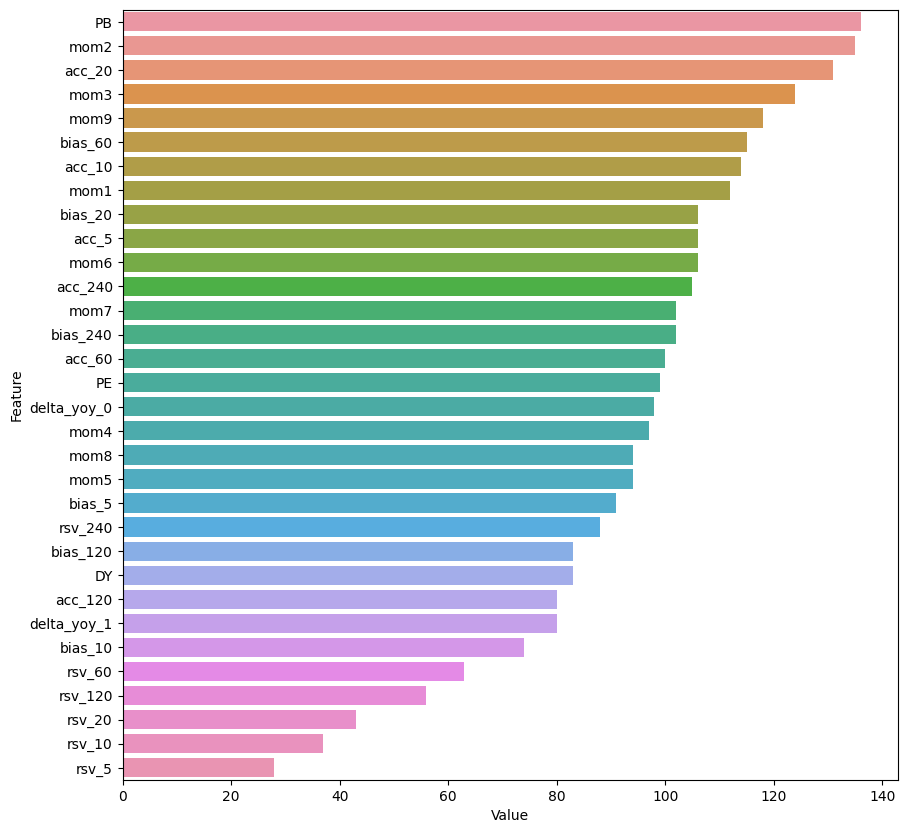

In [38]:
feature_imp = pd.DataFrame(zip(gs_best_model.feature_importances_, feature_names), 
                           columns=['Value','Feature']).sort_values('Value', ascending=False)
feature_imp

%matplotlib inline
import seaborn as sns
plt.figure(figsize=(10,10))
sns.barplot(x="Value", y="Feature", data=feature_imp)

### 3.xgboost Model

In [39]:
import xgboost as xgb
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

cf_xgb = xgb.XGBRegressor()
cf_xgb.fit(*train)
cf_xgb.score(*test)

-0.01256474699959087

In [40]:
import xgboost as xgb
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

from sklearn.model_selection import RandomizedSearchCV

reg = xgb.XGBRegressor()
param_grid = {
    #'silent': [False],
    'max_depth': [6, 10, 15, 20],
    'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3],
    'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bylevel': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'min_child_weight': [0.5, 1.0, 3.0, 5.0, 7.0, 10.0],
    'gamma': [0, 0.25, 0.5, 1.0],
    'reg_lambda': [0.1, 1.0, 5.0, 10.0, 50.0, 100.0],
    'n_estimators': [100]
}
fit_params = {
    'early_stopping_rounds': 10,
    'eval_set': [(test[0], test[1])],
    'verbose': False,
    'eval_metric': 'rmse'
    
}
xgb_rs = RandomizedSearchCV(reg, param_grid, n_iter=20, n_jobs=1, verbose=2, cv=2, scoring='neg_mean_squared_error', refit=True, random_state=42)
xgb_rs.fit(train[0], train[1], **fit_params) #*train

Fitting 2 folds for each of 20 candidates, totalling 40 fits
[CV] END colsample_bylevel=0.5, colsample_bytree=0.4, gamma=0, learning_rate=0.01, max_depth=6, min_child_weight=5.0, n_estimators=100, reg_lambda=50.0, subsample=0.7; total time=   1.7s
[CV] END colsample_bylevel=0.5, colsample_bytree=0.4, gamma=0, learning_rate=0.01, max_depth=6, min_child_weight=5.0, n_estimators=100, reg_lambda=50.0, subsample=0.7; total time=   1.7s
[CV] END colsample_bylevel=0.9, colsample_bytree=0.7, gamma=1.0, learning_rate=0.01, max_depth=20, min_child_weight=1.0, n_estimators=100, reg_lambda=1.0, subsample=0.6; total time=  15.0s
[CV] END colsample_bylevel=0.9, colsample_bytree=0.7, gamma=1.0, learning_rate=0.01, max_depth=20, min_child_weight=1.0, n_estimators=100, reg_lambda=1.0, subsample=0.6; total time=  14.7s
[CV] END colsample_bylevel=0.5, colsample_bytree=0.4, gamma=0.5, learning_rate=0.1, max_depth=15, min_child_weight=7.0, n_estimators=100, reg_lambda=50.0, subsample=0.9; total time=   3.3

RandomizedSearchCV(cv=2,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, gamma=None,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=100, n...
                                                              1.0],
                                        'colsample_bytree': [0.4, 0.5, 0.6, 0.7,
                                         

In [41]:
xgb_rs.best_params_

{'subsample': 0.9,
 'reg_lambda': 50.0,
 'n_estimators': 100,
 'min_child_weight': 7.0,
 'max_depth': 15,
 'learning_rate': 0.1,
 'gamma': 0.5,
 'colsample_bytree': 0.4,
 'colsample_bylevel': 0.5}

In [42]:
xgb_best_params = xgb_rs.best_params_
print("Best Parameters:", xgb_best_params)
print("----------------")
xgb_best_model = xgb.XGBRegressor(**best_params )
xgb_best_model.fit(*train)

Best Parameters: {'subsample': 0.9, 'reg_lambda': 50.0, 'n_estimators': 100, 'min_child_weight': 7.0, 'max_depth': 15, 'learning_rate': 0.1, 'gamma': 0.5, 'colsample_bytree': 0.4, 'colsample_bylevel': 0.5}
----------------
[11:26:52] WARNING: ../src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8491719215590814, gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_samples=121, min_child_weight=0.001, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=4,
             num_leaves=31, num_parallel_tree=1, random_state=0, reg_alpha=5,
             reg_lambda=10, scale_pos_weight=1, subsample=0.8356614850341461,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [43]:
xgb_best_params = xgb_rs.best_params_
print("Best Parameters:", xgb_best_params)
print("----------------")
xgb_best_model = xgb.XGBRegressor(**xgb_best_params )
xgb_best_model.fit(*train)

Best Parameters: {'subsample': 0.9, 'reg_lambda': 50.0, 'n_estimators': 100, 'min_child_weight': 7.0, 'max_depth': 15, 'learning_rate': 0.1, 'gamma': 0.5, 'colsample_bytree': 0.4, 'colsample_bylevel': 0.5}
----------------


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.5,
             colsample_bynode=1, colsample_bytree=0.4, gamma=0.5, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=15,
             min_child_weight=7.0, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=50.0, scale_pos_weight=1, subsample=0.9,
             tree_method='exact', validate_parameters=1, verbosity=None)

#### 結果

In [44]:
xgb_best_model.score(*test)

0.01915305337260409

In [45]:
#print('#Training accuracy {:.4f}'.format(reg.score(*train)))
#print('#Testing accuracy {:.4f}'.format(reg.score(*test)))
print('----------')
print('#[best]Training accuracy {:.4f}'.format(xgb_best_model.score(*train)))
print('#[best]Testing accuracy {:.4f}'.format(xgb_best_model.score(*test)))

----------
#[best]Training accuracy 0.1866
#[best]Testing accuracy 0.0192


<AxesSubplot:xlabel='Value', ylabel='Feature'>

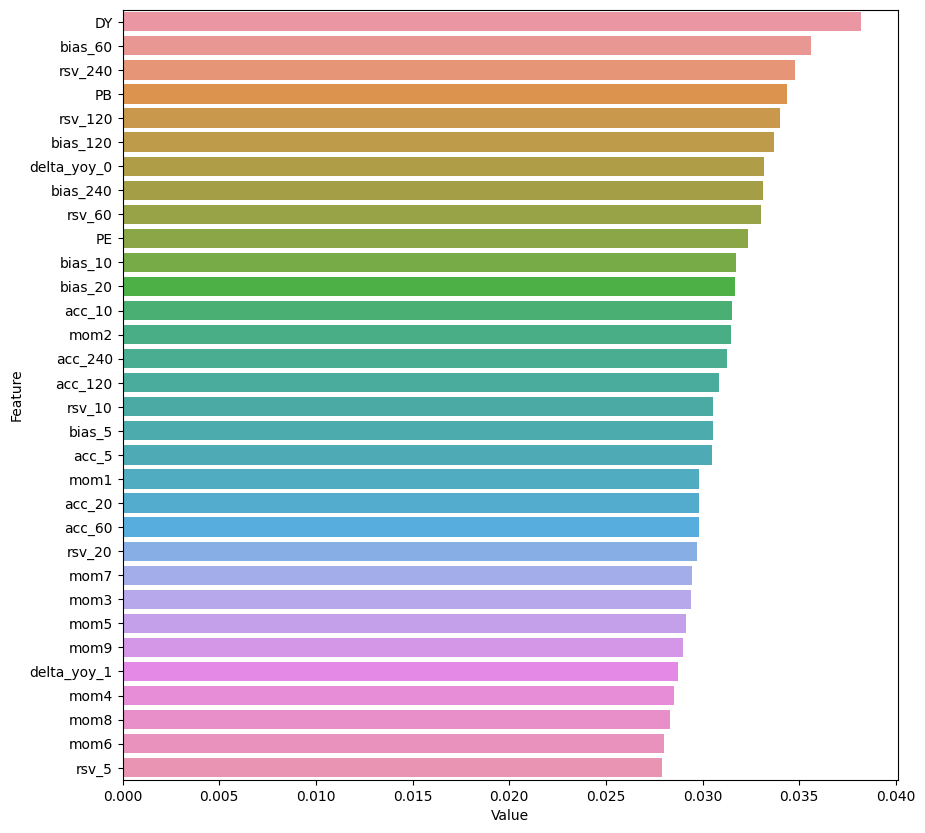

In [46]:
feature_imp = pd.DataFrame(zip(xgb_best_model.feature_importances_, feature_names), 
                           columns=['Value','Feature']).sort_values('Value', ascending=False)
feature_imp

%matplotlib inline
import seaborn as sns
plt.figure(figsize=(10,10))
sns.barplot(x="Value", y="Feature", data=feature_imp)

### 4.Random Forest Model
(20231114相關係數太高，先把它關掉)

In [47]:
from sklearn.ensemble import RandomForestRegressor

cf_rf = RandomForestRegressor(n_estimators=100)
cf_rf.fit(*train)
cf_rf.score(*test)

0.01064395545109198

<AxesSubplot:xlabel='Value', ylabel='Feature'>

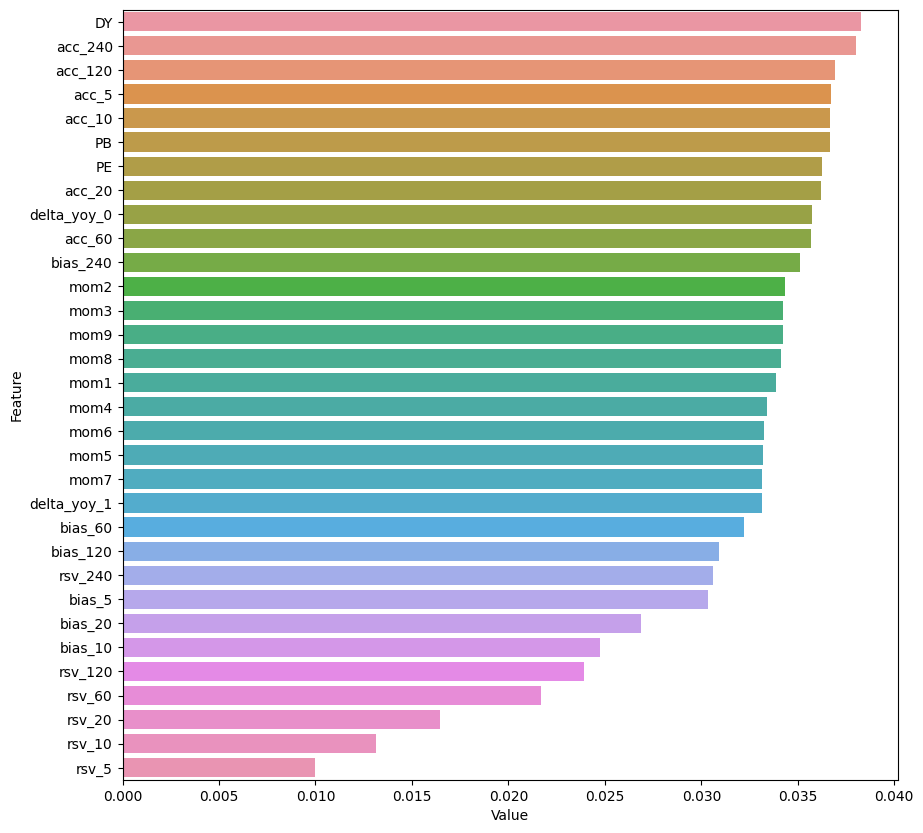

In [83]:
feature_imp = pd.DataFrame(zip(cf_rf.feature_importances_, feature_names), 
                           columns=['Value','Feature']).sort_values('Value', ascending=False)
feature_imp

%matplotlib inline
import seaborn as sns
plt.figure(figsize=(10,10))
sns.barplot(x="Value", y="Feature", data=feature_imp)

In [ ]:
from sklearn.ensemble import RandomForestRegressor 
from sklearn.model_selection import RandomizedSearchCV

rf = RandomForestRegressor()
# 参数取值范围
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 5, 8], 
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False]
}

# 随机搜索
rs = RandomizedSearchCV(rf,
                        param_grid,
                        n_iter=10,
                        cv=5,
                        n_jobs=-1,
                        random_state=42)

rf.fit(*train)
rf.score(*test)

# 拟合模型
rs.fit(*train)

# 输出最佳参数
print('最佳参数:', rs.best_params_)

In [84]:
rf_best_params = rs.best_params_

rf_best_model = RandomForestRegressor(**rf_best_params )
rf_best_model.fit(*train)

RandomForestRegressor(max_features='log2', min_samples_leaf=8)

In [71]:
rf_best_model.score(*test)

0.01798013174719515

In [85]:
print('#Training accuracy {:.4f}'.format(rs.score(*train)))
print('#Testing accuracy {:.4f}'.format(rs.score(*test)))
print('----------')
print('#[best]Training accuracy {:.4f}'.format(rf_best_model.score(*train)))
print('#[best]Testing accuracy {:.4f}'.format(rf_best_model.score(*test)))

#Training accuracy 0.4653
#Testing accuracy 0.0201
----------
#[best]Training accuracy 0.4650
#[best]Testing accuracy 0.0208


In [ ]:
#目前執行太久，後續再調整
#from sklearn.ensemble import RandomForestRegressor
#from sklearn.model_selection import RandomizedSearchCV
#
## 建立隨機森林回歸模型
#cf2 = RandomForestRegressor()
#
## 定義超參數範圍
#param_dist = {
#    'n_estimators': [50, 100, 200, 300],
#    'max_features': ['auto', 'sqrt', 'log2'],
#    'max_depth': [None, 10, 20, 30],
#    'min_samples_split': [2, 5, 10],
#    'min_samples_leaf': [1, 2, 4],
#    'bootstrap': [True, False]
#}
#
## 執行隨機參數搜尋
#rs = RandomizedSearchCV(cf2, param_distributions=param_dist, n_iter=100, cv=5, verbose=2, random_state=42)
#rs.fit(dataset_train[feature_names].astype(float), dataset_train['rank'])

在以上程式碼中，我們建立了 RandomForestRegressor 模型，\
並定義了超參數的範圍。使用 RandomizedSearchCV 進行參數搜尋，\
設定了迭代次數為 100，交叉驗證次數為 5，並設定了 random_state 來保持結果的可重現性。\
透過這樣的方式，您可以進一步優化 RandomForestRegressor 模型，以提高其性能。

### Ensemble learning

In [ ]:
dataset_drop = dataset.dropna(subset=feature_names+['return'])

vals = model.predict(dataset_drop[feature_names].astype(float))
dataset_drop['result1'] = pd.Series(vals.swapaxes(0,1)[0], dataset_drop.index)

vals = gs_best_model.predict(dataset_drop[feature_names].astype(float))
dataset_drop['result2'] = pd.Series(vals, dataset_drop.index)

vals = xgb_best_model.predict(dataset_drop[feature_names].astype(float))
dataset_drop['result3'] = pd.Series(vals, dataset_drop.index)

vals = rf_best_model.predict(dataset_drop[feature_names].astype(float))
dataset_drop['result4'] = pd.Series(vals, dataset_drop.index)

dataset_drop = dataset_drop.reset_index().set_index("date")

In [ ]:
result_col = ['result1','result2','result3','result4']
t1 = dataset_drop[result_col]

corr_matrix = t1.corr()
corr_matrix

# backtest

100%|████████████████████████████████████████| 166/166 [00:01<00:00, 114.99it/s]


<AxesSubplot:xlabel='date'>

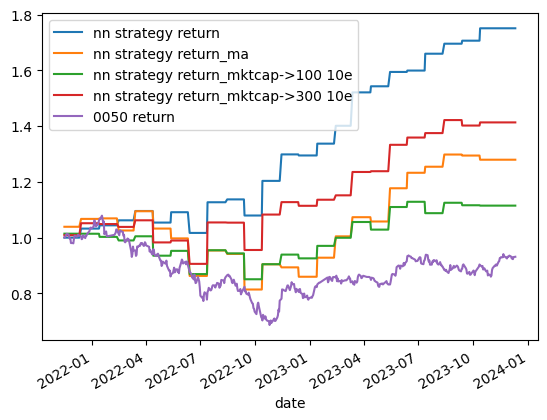

In [72]:
import math
from tqdm import tqdm

dates = sorted(list(set(dataset_drop.index)))
fil_ma_s = 1000  # start
fil_ma_e = 3000  # end

rs_1 = []
rs_2 = []
rs_3 = []  
rs_4 = []  
rs_5 = []  # 收益数据列表

for d in tqdm(dates):
    dataset_time = dataset_drop.loc[d]
    dataset_time = drop_extreme_case(dataset_time,
                                     ['PB', 'DY'],
    #                                 ['bias_60', 'bias_120', 'bias_240', 'mom1', 'mom2', 'mom3', 'mom4', 'mom5', 'mom6'],
    #                                 feature_names,
                                     thresh=0.01)
    predi_target_0 = dataset_time['result1'] + dataset_time['result2'] + dataset_time['result3'] + dataset_time['result4']
    predi_target_1 = predi_target_0.where((dataset_time['vol_ma5'] > fil_ma_s) & (dataset_time['vol_ma5'] < fil_ma_e) & (dataset_time['市值'] < 1e10), 0)
    predi_target_2 = predi_target_0.where((dataset_time['vol_ma5'] > fil_ma_s) & (dataset_time['市值'] < 1e9), 0)
    predi_target_3 = predi_target_0.where((dataset_time['vol_ma5'] < fil_ma_e) & (dataset_time['市值'] < 1e10), 0)
    predi_target_4 = predi_target_0.where((dataset_time['vol_ma5'] > fil_ma_e) & (dataset_time['市值'] > 1e9), 0)
    
        

    condition_0 = (predi_target_0 >= predi_target_0.nlargest(20).iloc[-1])
    condition_1 = (predi_target_1 >= predi_target_1.nlargest(20).iloc[-1])
    condition_2 = (predi_target_2 >= predi_target_2.nlargest(20).iloc[-1])
    condition_3 = (predi_target_3 >= predi_target_3.nlargest(20).iloc[-1])
    condition_4 = (predi_target_4 >= predi_target_4.nlargest(20).iloc[-1])

    
    r0 = dataset_time['return'][condition_0].mean()
    r1 = dataset_time['return'][condition_1].mean()
    r2 = dataset_time['return'][condition_2].mean()
    r3 = dataset_time['return'][condition_3].mean()
    r4 = dataset_time['return'][condition_4].mean()

    
    rs_1.append(r0 * (1 - 3 / 1000 - 1.425 / 1000 * 2 * 0.6))
    rs_2.append(r1 * (1 - 3 / 1000 - 1.425 / 1000 * 2 * 0.6))
    rs_3.append(r2 * (1 - 3 / 1000 - 1.425 / 1000 * 2 * 0.6))
    rs_4.append(r3 * (1 - 3 / 1000 - 1.425 / 1000 * 2 * 0.6))
    rs_5.append(r4 * (1 - 3 / 1000 - 1.425 / 1000 * 2 * 0.6))
    

rs_1 = pd.Series(rs_1, index=dates)[Aft:].cumprod()
rs_2 = pd.Series(rs_2, index=dates)[Aft:].cumprod()
rs_3 = pd.Series(rs_3, index=dates)[Aft:].cumprod()
rs_4 = pd.Series(rs_4, index=dates)[Aft:].cumprod()
rs_5 = pd.Series(rs_5, index=dates)[Aft:].cumprod()

s0050 = close['0050'][Aft:]

pd.DataFrame(
    {
        'nn strategy return': rs_1.reindex(s0050.index, method='ffill'),
        'nn strategy return_ma': rs_2.reindex(s0050.index, method='ffill'),
        'nn strategy return_mktcap->100 10e': rs_3.reindex(s0050.index, method='ffill'),
        #'nn strategy return_mktcap-<300 10e': rs_4.reindex(s0050.index, method='ffill'),
        'nn strategy return_mktcap->300 10e': rs_5.reindex(s0050.index, method='ffill'),
        '0050 return': s0050 / s0050[0],
    }
).plot()


In [73]:
dataset_time['result1'] + dataset_time['result2'] + dataset_time['result3']+ dataset_time['result4']

date
2023-10-13    1.883757
2023-10-13    2.136929
2023-10-13    2.068966
2023-10-13    2.044521
2023-10-13    2.176768
                ...   
2023-10-13    1.995341
2023-10-13    1.965385
2023-10-13    1.994198
2023-10-13    1.882117
2023-10-13    1.924353
Length: 1087, dtype: float64

In [74]:
dataset_time

,stock_id,mom1,mom2,mom3,mom4,mom5,mom6,mom7,mom8,mom9,...,delta_yoy_0,delta_yoy_1,vol_ma5,市值,return,rank,result1,result2,result3,result4
date,,,,,,,,,,,,,,,,,,,,,
2023-10-13,1101,1.047573,1.015580,0.918719,1.054502,0.775774,1.605565,0.997385,0.582099,1.300745,...,-0.037888,-0.008853,20724.76655,7.760704e+11,0.973373,0.304360,0.473671,0.469112,0.455394,0.485580
2023-10-13,1102,0.952830,1.017837,0.921617,1.009714,0.879294,1.306309,1.296343,0.577242,1.004147,...,0.041584,0.051836,3969.95785,4.677171e+11,1.004944,0.584938,0.522009,0.544413,0.563113,0.507394
2023-10-13,1104,0.968538,1.054584,0.900513,1.041817,0.871040,1.250067,1.172781,0.695641,1.147553,...,0.016594,-0.078607,1247.03485,4.469059e+10,1.054264,0.835221,0.515805,0.519231,0.540690,0.493240
2023-10-13,1108,0.975693,0.995896,0.917174,1.219080,0.908584,1.205342,1.226676,0.704955,1.090035,...,0.062493,-0.246846,423.91330,9.735866e+09,1.038732,0.785957,0.502603,0.508495,0.509676,0.523748
2023-10-13,1109,0.963024,1.088910,0.823273,1.135974,0.883525,1.521342,1.378984,0.577380,0.770836,...,-0.359400,0.123472,113.69840,1.140851e+10,1.000000,0.536806,0.538822,0.560488,0.551603,0.525856
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-13,9943,0.968543,1.012284,1.138465,0.821535,1.304666,0.829330,0.672598,1.325632,1.228326,...,-0.021947,-0.119029,156.75355,2.348920e+10,1.027397,0.742922,0.500484,0.505861,0.497049,0.491947
2023-10-13,9946,1.336136,0.773231,1.427930,0.607760,1.212820,1.314014,3.200011,0.700310,0.201046,...,0.192282,-0.006065,336.51010,1.245666e+10,1.141994,0.954134,0.550740,0.484590,0.457784,0.472270
2023-10-13,9951,1.207436,0.891870,1.065317,1.121652,0.808777,1.085135,1.114727,0.727585,1.013367,...,0.023242,-0.148246,322.55235,1.277556e+10,1.017196,0.676670,0.495088,0.506500,0.493476,0.499133


### 當月持股狀況

In [75]:
dataset.index.levels[1].max()

Timestamp('2023-12-13 00:00:00')

30/30 [==============================] - 0s 748us/step


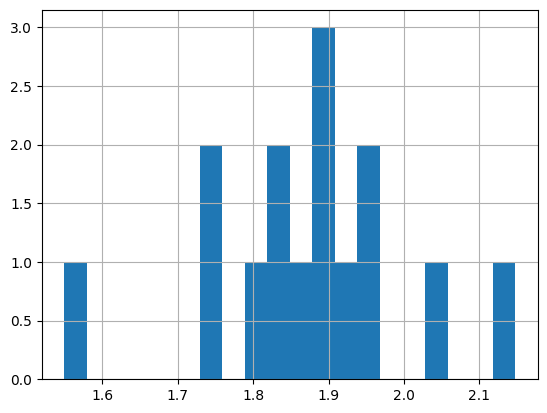

In [76]:
# get the latest dataset
last_date = dataset.index.levels[1].max()#"2022-10-15"
is_last_date = dataset.index.get_level_values('date') == last_date
last_dataset = dataset[is_last_date].copy()


last_dataset = drop_extreme_case(last_dataset,
                                 #['bias_60', 'bias_120', 'bias_240', 'mom1', 'mom2', 'mom3', 'mom4', 'mom5', 'mom6'],
                                 feature_names,
                                 thresh=0.01
                                )


# remove NaN testcases
last_dataset = last_dataset.dropna(subset=feature_names)

# predict

vals = model.predict(last_dataset[feature_names].astype(float))
last_dataset['result1'] = pd.Series(vals.swapaxes(0,1)[0], last_dataset.index)

vals = gs_best_model.predict(last_dataset[feature_names].astype(float))
last_dataset['result2'] = pd.Series(vals, last_dataset.index)

vals = xgb_best_model.predict(last_dataset[feature_names].astype(float))
last_dataset['result3'] = pd.Series(vals, last_dataset.index)

vals = rf_best_model.predict(last_dataset[feature_names].astype(float))
last_dataset['result4'] = pd.Series(vals, last_dataset.index)

# calculate score

rank = last_dataset['result1'] + last_dataset['result2'] + last_dataset['result3']+ last_dataset['result4']
#rank_target = rank.where((last_dataset['vol_ma5'] > fil_ma_s)  & (last_dataset['vol_ma5'] < fil_ma_e)  & (last_dataset['市值'] < 1e10), 0)
rank_target = rank.where((last_dataset['vol_ma5'] > fil_ma_e)  & (last_dataset['市值'] < 1e10), 0)

condition = (rank_target >= rank_target.nlargest(15).iloc[-1]) 

# plot rank distribution
rank_target[rank_target != 0].hist(bins=20)


# show the best 20 stocks
slist1 = rank_target[rank_target != 0].reset_index()['stock_id']

In [77]:
last_dataset

,,mom1,mom2,mom3,mom4,mom5,mom6,mom7,mom8,mom9,bias_5,...,delta_yoy_0,delta_yoy_1,vol_ma5,市值,return,rank,result1,result2,result3,result4
stock_id,date,,,,,,,,,,,,,,,,,,,,,
1101,2023-12-13,1.072877,0.931312,1.047573,1.015580,0.918719,1.054502,0.775774,1.605565,0.997385,0.994220,...,0.083857,-0.015133,27247.38695,7.898468e+11,NaN,NaN,0.498974,0.480531,0.479370,0.463700
1102,2023-12-13,1.002131,1.034324,0.952830,1.017837,0.921617,1.009714,0.879294,1.306309,1.296343,1.003357,...,-0.049640,-0.074533,5450.97160,4.821172e+11,NaN,NaN,0.546581,0.569502,0.551297,0.566923
1103,2023-12-13,1.104576,0.975146,0.896059,0.961758,1.217018,1.034162,0.884147,1.180455,1.103720,1.001565,...,-0.076978,0.093763,284.06345,2.851992e+10,NaN,NaN,0.500504,0.522316,0.534920,0.523056
1104,2023-12-13,1.058071,1.002260,0.968538,1.054584,0.900513,1.041817,0.871040,1.250067,1.172781,1.007591,...,0.199977,-0.005130,908.56970,5.028767e+10,NaN,NaN,0.571121,0.602636,0.630049,0.595103
1108,2023-12-13,1.116226,0.939015,0.975693,0.995896,0.917174,1.219080,0.908584,1.205342,1.226676,1.007242,...,0.188048,-0.041498,420.44445,1.049005e+10,NaN,NaN,0.540924,0.552807,0.522629,0.553780
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9943,2023-12-13,1.006550,0.981671,0.968543,1.012284,1.138465,0.821535,1.304666,0.829330,0.672598,0.977036,...,-0.068963,-0.078533,300.64545,2.415879e+10,NaN,NaN,0.452365,0.447140,0.447907,0.450309
9946,2023-12-13,1.935862,0.669471,1.336136,0.773231,1.427930,0.607760,1.212820,1.314014,3.200011,0.963280,...,-0.386213,0.810993,734.69720,1.441360e+10,NaN,NaN,0.489969,0.476418,0.480842,0.437529
9951,2023-12-13,1.046322,1.014214,1.207436,0.891870,1.065317,1.121652,0.808777,1.085135,1.114727,1.009529,...,-0.099655,0.124255,153.53765,1.323123e+10,NaN,NaN,0.531412,0.587994,0.588109,0.590497


# 平均分配資產於股票之中

In [78]:
condition

stock_id  date      
1101      2023-12-13    False
1102      2023-12-13    False
1103      2023-12-13    False
1104      2023-12-13    False
1108      2023-12-13    False
                        ...  
9943      2023-12-13    False
9946      2023-12-13    False
9951      2023-12-13    False
9960      2023-12-13    False
9962      2023-12-13    False
Length: 937, dtype: bool

In [79]:
close = data.get("收盤價")

money = 321579
stock_prices = close[rank_target[condition].reset_index()['stock_id']].iloc[-1]


print("股票平分張數:")
money / len(stock_prices) / stock_prices / 1000


股票平分張數:


stock_id
1568    0.605610
1584    0.606467
1603    0.556847
2425    0.443404
2641    0.978932
3047    1.374269
3050    1.207808
3094    0.534628
3276    0.849053
4533    0.746990
5452    0.875045
6243    0.292477
6485    0.181683
6530    0.399974
8088    0.475357
Name: 2023-12-11 00:00:00, dtype: float64

In [80]:
import pyfolio as pf

import pickle
pickle.dump(rs_2, open('230618_return_history.pkl', 'wb'))

In [81]:
 rs_2

2021-11-13    1.038493
2021-12-13    1.066727
2022-01-13    1.068593
2022-02-13    1.025143
2022-03-13    1.094330
2022-04-13    1.032046
2022-05-13    0.996793
2022-06-13    0.862168
2022-07-13    0.953479
2022-08-13    0.941040
2022-09-13    0.813423
2022-10-13    0.903828
2022-11-13    0.892892
2022-12-13    0.859205
2023-01-13    0.927527
2023-02-13    1.004135
2023-03-13    1.072834
2023-04-13    1.057434
2023-05-13    1.176645
2023-06-13    1.232202
2023-07-13    1.253902
2023-08-13    1.297662
2023-09-13    1.294005
2023-10-13    1.279074
dtype: float64

In [82]:
pf.tears.create_capacity_tear_sheet(rs_2)

TypeError: create_capacity_tear_sheet() missing 3 required positional arguments: 'positions', 'transactions', and 'market_data'

In [ ]:
import pickle
import pandas as pd

# 得到 上面的 回測結果
ret = pickle.load(open("230618_return_history.pkl", "rb"))

# 將回測報酬率取出來
ret = ret.pct_change().dropna()
#ret.index = pd.to_datetime(ret.index).tz_localize('Asia/Taipei')

# 利用pyfolio 比較報酬率

pf.create_returns_tear_sheet(ret, benchmark_rets=close['0050'].reindex(ret.index, method='ffill').pct_change())

###################################################################################################
## 移動窗格最佳化
[有空來試試看連結](https://hahow.in/courses/5b9d3a6dca498a001e917383/discussions/61b4c90147843d0006cf2593)

###################################################################################################

In [ ]:
train = dataset_train[feature_names].astype(float) , dataset_train['return'] #> 1.00
test = dataset_test[feature_names].astype(float) , dataset_test['return'] #> 1.00

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# 創建Random Forest模型
random_forest = RandomForestRegressor(n_estimators=100)

# 使用訓練資料訓練模型
random_forest.fit(*train)

# 使用測試資料評估模型
accuracy = random_forest.score(*test)
print("Random Forest 模型的準確率：", accuracy)

In [ ]:
import lightgbm as lgb

from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt

import numpy as np

%matplotlib inline

def select(df):

    rank = df['pre']

    condition1 = (rank >= rank.nlargest(1).iloc[-1])

    return df['return'][condition1].mean() * (1-3/1000-1.425/1000*2*0.6)

end = 5

cf = lgb.LGBMRegressor(n_estimators=500)



train_time = ['2015','2016','2017','2018','2019']

s_time = ['2007','2008','2009','2010','2011']

test_time = ['2016','2017','2018','2019','2020']

dataset_copy = dataset_dropna.copy()

store_mse = []

In [ ]:
for time in range(end):

    print('%d 次執行中'%(time+1))

    dataset_dropna2_train = dataset_copy.loc[s_time[time]:train_time[time]] #2007~ 2015   2008~2016   2009~2017  2010~2018  ....

    dataset_dropna2_test = dataset_copy.loc[test_time[time]:test_time[time]]#            2016                2017               2018              2019  .....

    
    cf.fit(dataset_dropna2_train[feature_names].astype(float), dataset_dropna2_train['rank'])
    predict = cf.predict(dataset_dropna2_test[feature_names])

    dataset_dropna2_test['pre'] = predict

    dates = dataset_dropna2_test.index.get_level_values('date')
    
    b = dataset_dropna2_test.groupby(dates).apply(select).cumprod()
    
    s0050 = close['0050'][test_time[time]:test_time[time]]
    
    s0056 = close['0056'][test_time[time]:test_time[time]]
    
    pd.DataFrame({'Best 1 stocks return(include handling fee)':b.reindex(s0050.index, method='ffill'), 
    
                  '0050':s0050/s0050[0],'0056':s0056/s0056[0]}).plot()
    
    plt.ylabel('return')



In [ ]:
cf.predict(dataset_dropna2_test[feature_names])

In [ ]:
dataset_dropna2_train[feature_names].astype(float)